# Load DE genes
Use publication's cell type specific genes

In [1]:
import pandas as pd
import numpy as np
specific_gene = pd.read_excel('neuron_specific_gene.xlsx', header = 2)
specific_gene.head() # only need Cell Type

,Zhang2016_logFC,Darmanis2015_logFC,Zhang2014_logFC,Zeisel2014_logFC,Tasic2016_logFC,grand_mean,gene,Celltype
0,5.691528,7.240669,6.433235,6.127016,8.593735,6.817237,AQP4,ast
1,6.577394,6.326526,4.693049,4.388683,8.720270,6.141184,GJA1,ast
2,5.695915,5.405528,4.078450,4.306402,8.780514,5.653362,GJB6,ast
3,5.639545,5.082093,6.146746,4.407424,6.674747,5.590111,SLC4A4,ast
4,5.733010,6.043242,5.003034,5.005239,5.568579,5.470621,SLC1A2,ast


In [2]:
for name, g in specific_gene.groupby(by = 'Celltype')['gene']: # top 1000 enrichmed genes in each cell type
    print(name, len(list(g)))
# this publication produces 1000 top differentially expressed gene for each cell type
# we sought to find what "functions" they are all doing

ast 1000
end 1000
mic 1000
neu 1000
oli 1000
opc 1000


In [3]:
def de_term(ont, specific_gene):
    '''
    find de term per ontology. De term is defined as 1%
    ont: ddot.Ontology
    specific gene: dataframe per with column ['gene, 'Celltype']
    return de_term_dict for each cell type
    '''
    
    
    ont_pro = ont.propagate(direction = 'forward')
    ont_tbl = ont.to_table()
    
    # find background distribution
    all_p = ont_tbl.loc[ont_tbl['EdgeType']== 'Gene-Term'].groupby(by = 'Parent').count()
    all_genes = ont_tbl.loc[ont_tbl['EdgeType']== 'Gene-Term']['Child'].unique()
    
    background_gene_count = pd.DataFrame(index = all_p.index)
    
    # sample 1000 genes for constructing background distribution for each term
    n_iter = 0
    while n_iter < 100:
        # randomly choose 1000 gebe
        rand_index = np.random.choice(len(all_genes), 1000, replace=False)
        rand_genes = all_genes[rand_index]
    
        background_gene_count[n_iter] = (ont_tbl.loc[ont_tbl['Child'].isin(rand_genes)].groupby(by = 'Parent').count()['Child'])
        n_iter+=1
    background_gene_count.fillna(0, inplace = True)
    threshold = background_gene_count.quantile(axis = 1, q = 0.99)
    
    # propagate the cell-type specific genes along ontology, and see what terms are enriched
    de_term_dict = {}
    for name, g in specific_gene.groupby(by = 'Celltype')['gene']: # top 1000 enrichmed genes in each cell type
    
        cell_specific_gene_count = ont_tbl.loc[ont_tbl['Child'].isin(g)].groupby(by = 'Parent').count()['Child'] # each term has how many cell type specific genes
        # how many of them exceed 99 percentile?
        de_term = ont_tbl.loc[ont_tbl['Child'].isin(g)].groupby(by = 'Parent').count()['Child'].ge(threshold)
        de_term_dict[name] = list(de_term.loc[de_term].index)
    return(de_term_dict)

In [6]:
ent_thres = np.arange(start = 0.05, stop = 1, step = 0.05)
data_root = '/cellar/users/hsher/ontoPrune/data/'
import pickle
from ddot import Ontology
def wrapper(e_thres):
    '''
    run DE term for ontology of different threshold
    '''
    print("running ", e_thres)
    
    # read ontology
    go = Ontology.read_pickle(data_root+'prune_go_{:.2f}'.format(e_thres))
    no_terms = len(go.terms)
    
    dterms = de_term(go, specific_gene)
    no_de_term = [len(dterms[cell]) for cell in dterms.keys()]
    
    # save to file
    with open(data_root+"one_percent_term_{:.2f}".format(e_thres), "wb") as fp:   #Pickling
        pickle.dump(dterms, fp)
    
    return(no_terms, no_de_term)

In [7]:
de_term_stat = pd.DataFrame(index = ent_thres, columns = ['total_terms','ast', 'end', 'mic', 'neu', 'oli', 'opc'])
for e in ent_thres:
    no_terms, no_de_terms = wrapper(e)
    de_term_stat.loc[e] = [no_terms]+no_de_terms

running  0.05
running  0.1
running  0.15000000000000002
running  0.2
running  0.25
running  0.3
running  0.35000000000000003
running  0.4
running  0.45
running  0.5
running  0.55
running  0.6000000000000001
running  0.6500000000000001
running  0.7000000000000001
running  0.7500000000000001
running  0.8
running  0.8500000000000001
running  0.9000000000000001
running  0.9500000000000001


In [8]:
de_term_stat

,total_terms,ast,end,mic,neu,oli,opc
0.05,17158,1989,1969,2295,1471,1336,1362
0.10,17038,1929,1956,2310,1453,1341,1359
0.15,16911,1970,2012,2285,1485,1345,1401
0.20,16760,1956,1916,2269,1436,1289,1349
0.25,16444,1915,1966,2324,1439,1273,1388
0.30,16086,1891,1943,2237,1420,1257,1346
0.35,15538,1916,1914,2238,1384,1274,1354
0.40,14864,1938,1923,2246,1389,1224,1329
0.45,13742,1768,1789,2122,1288,1118,1251
0.50,12305,1582,1554,1867,1155,979,1087


In [11]:
de_term_stat.columns

Index(['total_terms', 'ast', 'end', 'mic', 'neu', 'oli', 'opc'], dtype='object')

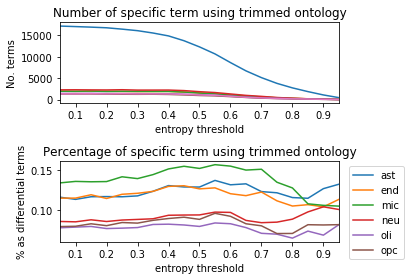

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

f, ax = plt.subplots(2,1)

de_term_stat.plot(ax = ax[0], legend = False)
ax[0].set_xlabel('entropy threshold')
ax[0].set_ylabel('No. terms')
ax[0].set_title('Number of specific term using trimmed ontology')

percentage_term = de_term_stat[['ast', 'end', 'mic', 'neu', 'oli', 'opc']].div(de_term_stat['total_terms'], axis = 0)
percentage_term.plot(ax = ax[1], legend = False)
ax[1].set_xlabel('entropy threshold')
ax[1].set_ylabel('% as differential terms')
ax[1].set_title('Percentage of specific term using trimmed ontology')
ax[1].legend(bbox_to_anchor=(1.25, 1))

plt.tight_layout()

# Why sometimes root gets enriched

Because the number of annotation for each 1000 de-genes are not equal.

In [22]:
neu_gene = specific_gene.loc[specific_gene['Celltype'] == 'neu', 'gene'].tolist()
mic_gene = specific_gene.loc[specific_gene['Celltype'] == 'mic', 'gene'].tolist()

In [23]:
from ddot import Ontology
data_root = '~/ontoPrune/data/'
go = Ontology.read_pickle(data_root+'prune_go_{:.2f}'.format(0.95))

In [24]:
go

19626 genes, 477 terms, 64852 gene-term relations, 478 term-term relations
node_attributes: []
edge_attributes: ['Annotation Extension', 'Aspect', 'Assigned By', 'DB', 'DB Object ID', 'DB Object Name', 'DB Object Synonym', 'DB Object Type', 'DB:Reference', 'Date', 'Evidence Code', 'Gene Product Form ID', 'Qualifier', 'Taxon', 'With (or) From', 'biological_process', 'is_a']

In [25]:
go.get_roots()

['GO:0003674', 'GO:0005575', 'GO:0008150']

In [26]:
go.connected(ancestors = go.get_roots(), descendants = list(set(neu_gene).intersection(set(go.genes)))).sum(axis = 0)

array([863, 933, 891])

In [27]:
go.connected(ancestors = go.get_roots(), descendants = list(set(mic_gene).intersection(set(go.genes)))).sum(axis = 0)

array([930, 950, 931])

In [28]:
len(set(neu_gene).intersection(set(go.genes)))

952

In [29]:
len(set(mic_gene).intersection(set(go.genes)))

969